# Intro
---- Note: skip data Engineering (or only the reviews classification) and load directly the gold data to avoid longer runtime ----

---- [YouTube video](https://youtu.be/W0iqFKk_m5o?si=kZT35cn5L9GpGuR9) ----

In this analysis we have a dtaset of 10000 restaurant reviwews. We would like to understand who is often reviewing restaurants and what does affect this behaviour:
- we will study the relationship between the number of reviews that the user did, the restaurant has, and the review the user gave.
- when does a user who doesn't regularaly do reviews gives a review?
    - positive-negative-long-short?
    - When his opinion is similar or different?
    - When the restaurant already has too many or too less reviews?
- How honest are the people who give too many reviews?
    - can we tell this by just comparing their reviews to the avarage reviews of the restaurant?
    - do they always give positive or negative? and how do their opinions vary from the others?
- We will also use the Time of review to predict the meal
- How does the times of the year corelate with the ammount and quality of reviews
- Add sentiment analysis?!
- based on the sentiment, how do ratings relate to the evaluation of the review

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# to fit the aspect ration of te video
plt.rcParams['figure.figsize'] = [6, 12]

# Data Engineering
Data engineering doesn't only envolve reducing the dimension of the dataset. It can also envolve extending it, by extracting more information out of the available data. The initial dataset had 8 columns. by removing two columns and adding 8 columns we ended up with 9 columns. The added columns include some ctegories that could be extracted out of the data by envolving sentiment analysis for the review texts and using the time (temporal features) to predict the meal and the season. For more details you can check the notebook by clicking on the github link in the description.

## Basic

In [ ]:
df = pd.read_csv("Restaurant reviews.csv")

In [ ]:
# Drop nans
df = df.dropna(subset='Rating')
df.Rating.isna().sum()

0

In [ ]:
#check duplications
df.duplicated().sum()

0

In [ ]:
# Create a mapping of unique (Reviewer, Metadata) combinations to unique IDs. different reviewers with the same names exist in the data
unique_combinations = df.drop_duplicates(subset=['Reviewer', 'Metadata']).reset_index(drop=True)
unique_combinations['User_ID'] = [str(i+1) for i in range(len(unique_combinations))]

# Create a dictionary for mapping (Reviewer, Metadata) to ID
combination_to_id = {(row['Reviewer'], row['Metadata']): row['User_ID'] for index, row in unique_combinations.iterrows()}

In [ ]:
# Add the ID column to the original DataFrame
df['User_ID'] = df.apply(lambda row: combination_to_id[(row['Reviewer'], row['Metadata'])], axis=1)
df = df.drop(columns=['Reviewer'], axis=0)

In [ ]:
df.Rating.isna().sum()

0

In [ ]:
df['User_ID'].value_counts().reset_index()

,User_ID,count
0,859,13
1,1530,11
2,1140,11
3,1131,10
4,391,10
...,...,...
7912,3024,1
7913,3023,1
7914,3022,1
7915,3020,1


In [ ]:
# unique users have now unique metadata
df.loc[df.User_ID=='859']

,Restaurant,Review,Rating,Metadata,Time,Pictures,7514,User_ID
875,Hyper Local,"We have ordered Mutton Galouti, Chholey calzon...",4,"146 Reviews , 333 Followers",3/31/2019 23:57,4,NaN,859
1245,Absolute Sizzlers,We had a very bad experience here. We have ord...,2,"146 Reviews , 333 Followers",4/8/2019 23:54,1,NaN,859
1621,NorFest - The Dhaba,A must try place for north indian food lovers....,4,"146 Reviews , 333 Followers",1/31/2019 23:51,0,NaN,859
2695,Mustang Terrace Lounge,The have a great ambience. The view from the r...,4,"146 Reviews , 333 Followers",1/31/2019 22:50,0,NaN,859
3027,Pot Pourri,We visited this restaurant recently. We have o...,3,"146 Reviews , 333 Followers",4/8/2019 19:20,2,NaN,859
3282,Marsala Food Company,I have visited this restaurant with a group of...,2,"146 Reviews , 333 Followers",2/28/2019 22:33,0,NaN,859
3380,Club Rogue,The non veg starter items (specially chicken) ...,3,"146 Reviews , 333 Followers",1/31/2019 23:48,0,NaN,859
3712,Kritunga Restaurant,Nice Andhra style spicy food in decent price. ...,3,"146 Reviews , 333 Followers",1/31/2019 23:06,0,NaN,859
5328,Diners Pavilion,The ambience is really nice. The food items ar...,3,"146 Reviews , 333 Followers",2/28/2019 22:35,0,NaN,859
5404,Asian Meal Box,I have ordered few non veg combos from here co...,3,"146 Reviews , 333 Followers",4/30/2019 23:50,0,NaN,859


In [ ]:
df.Rating.unique()

array(['5', '4', '1', '3', '2', '3.5', '4.5', '2.5', '1.5', 'Like'],
      dtype=object)

In [ ]:
df.Rating = pd.to_numeric(df['Rating'], errors='coerce')
# again to drop the 'like'
df = df.dropna(subset=['Rating', 'Review'])

## extracting amount of followers and reviews
It seems that there are different patterns in the column Metadata. We want to extract the amount of followers and reviews and write them into two neumiric columns

In [ ]:
def extract_patterns(metadata):
    patterns = set()
    for row in metadata:
        words = re.findall(r'\b[A-Za-z]+\b', row)
        patterns.add(tuple(words))
    return patterns

extract_patterns(df['Metadata'])

{('Post', 'Followers'),
 ('Posts', 'Followers'),
 ('Review',),
 ('Review', 'Follower'),
 ('Review', 'Followers'),
 ('Reviews',),
 ('Reviews', 'Follower'),
 ('Reviews', 'Followers')}

In [ ]:
def extract_numbers(metadata):
    reviews = []
    followers = []
    for row in metadata:
        review_match = re.search(r'(\d+)\s*(?:Review|Reviews|Post|Posts)', row)
        reviews.append(int(review_match.group(1)) if review_match else 999999999) # 999999999 to test if the search was correct

        follower_match = re.search(r'(\d+)\s*(?:Follower|Followers)', row)
        followers.append(int(follower_match.group(1)) if follower_match else 0)

    return reviews, followers

# Extracting numbers for reviews and followers
df['Reviews'], df['Followers'] = extract_numbers(df['Metadata'])

<ipython-input-14-93220eb45229>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Reviews'], df['Followers'] = extract_numbers(df['Metadata'])
<ipython-input-14-93220eb45229>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Reviews'], df['Followers'] = extract_numbers(df['Metadata'])


In [ ]:
df.head(5)

,Restaurant,Review,Rating,Metadata,Time,Pictures,7514,User_ID,Reviews,Followers
0,Beyond Flavours,"The ambience was good, food was quite good . h...",5.0,"1 Review , 2 Followers",5/25/2019 15:54,0,2447.0,1,1,2
1,Beyond Flavours,Ambience is too good for a pleasant evening. S...,5.0,"3 Reviews , 2 Followers",5/25/2019 14:20,0,NaN,2,3,2
2,Beyond Flavours,A must try.. great food great ambience. Thnx f...,5.0,"2 Reviews , 3 Followers",5/24/2019 22:54,0,NaN,3,2,3
3,Beyond Flavours,Soumen das and Arun was a great guy. Only beca...,5.0,"1 Review , 1 Follower",5/24/2019 22:11,0,NaN,4,1,1
4,Beyond Flavours,Food is good.we ordered Kodi drumsticks and ba...,5.0,"3 Reviews , 2 Followers",5/24/2019 21:37,0,NaN,5,3,2


In [ ]:
df.Reviews.isna().sum(), df.Followers.isna().sum()

(0, 0)

In [ ]:
# Check if all the reviews are written correctly
df.loc[df.Reviews==999999999]

,Restaurant,Review,Rating,Metadata,Time,Pictures,7514,User_ID,Reviews,Followers


In [ ]:
#now we drop the Metadata Column
df = df.drop(columns=['Metadata', '7514'])

In [ ]:
# is there still any missing values? it is okay if there are 7 missing reviews
df.isnull().sum().to_frame().rename(columns={0:"Total Num of Missing Values"})

,Total Num of Missing Values
Restaurant,0
Review,0
Rating,0
Time,0
Pictures,0
User_ID,0
Reviews,0
Followers,0


## new columns

In [ ]:
len(df)

9954

In [ ]:
len(df['Review'][0])

222

In [ ]:
# there are some emojies
df.iloc[1583].Review

'😄'

In [ ]:
# Convert 'Review_Text' to string, replace NaNs with empty strings, and remove punctuation
df['Review'] = df['Review'].astype(str).fillna('').str.lower().str.replace('[^\w\s]', '', regex=True)

In [ ]:
mask = df['Review'].apply(len) == 0
df[mask]

,Restaurant,Review,Rating,Time,Pictures,User_ID,Reviews,Followers
1583,KFC,,5.0,7/26/2018 23:27,0,1508,0,0
3784,Kritunga Restaurant,,5.0,7/25/2018 20:25,0,3332,0,0
4573,Owm Nom Nom,,5.0,7/25/2018 21:11,0,3933,0,0
4582,Owm Nom Nom,,5.0,7/22/2018 21:21,0,3941,1,0
5280,Biryanis And More,,5.0,7/18/2018 22:59,0,4462,1,0
6274,Shree Santosh Dhaba Family Restaurant,,5.0,7/17/2018 13:41,0,5192,1,1
6281,Shree Santosh Dhaba Family Restaurant,,5.0,7/14/2018 21:52,0,5199,1,1
6659,Aromas@11SIX,,5.0,8/22/2018 13:10,0,5496,1,1
8830,Domino's Pizza,,4.0,9/2/2018 20:28,0,7068,2,4
9597,Desi Bytes,,1.0,4/18/2018 18:13,0,7637,5,1


In [ ]:
# fill them all with good
df.loc[mask, 'Review'] = "good"

In [ ]:
# Add a column for the length of each review
df['Review_Length'] = df['Review'].apply(len)

In [ ]:
def classify_sentiment(review):
    return 'positive' if review >= 3 else 'negative'

df['Sentiment'] = df['Rating'].apply(classify_sentiment)

## seasons and meals

In [ ]:
df['Time'] = pd.to_datetime(df['Time'], format='%m/%d/%Y %H:%M', errors='coerce')

In [ ]:
def determine_meal(time):
    if 6 <= time.hour < 11:
        return 'breakfast'
    elif 11 <= time.hour < 18:
        return 'lunch'
    else:
        return 'dinner'

df['meal'] = df['Time'].apply(determine_meal)

def determine_season(date):
    year = date.year
    spring_start = pd.Timestamp(year=year, month=3, day=20)
    summer_start = pd.Timestamp(year=year, month=6, day=21)
    fall_start = pd.Timestamp(year=year, month=9, day=22)
    winter_start = pd.Timestamp(year=year, month=12, day=21)

    if spring_start <= date < summer_start:
        return f'spring'
    elif summer_start <= date < fall_start:
        return f'summer'
    elif fall_start <= date < winter_start:
        return f'fall'
    else:
        return f'winter'

df['season'] = df['Time'].apply(determine_season)
df = df.drop(columns=['Time'])

df.head(3)

,Restaurant,Review,Rating,Pictures,User_ID,Reviews,Followers,Review_Length,Sentiment,meal,season
0,Beyond Flavours,the ambience was good food was quite good had...,5.0,0,1,1,2,215,positive,lunch,spring
1,Beyond Flavours,ambience is too good for a pleasant evening se...,5.0,0,2,3,2,139,positive,lunch,spring
2,Beyond Flavours,a must try great food great ambience thnx for ...,5.0,0,3,2,3,175,positive,dinner,spring


## ctegorize the reviewers
study th distribution to be able to decide thresholds for the categories

In [ ]:
df.describe()

,Rating,Pictures,Reviews,Followers,Review_Length
count,9954.000000,9954.000000,9954.000000,9954.000000,9954.000000
mean,3.600261,0.751959,24.007937,163.122363,271.121358
std,1.483573,2.575819,50.631674,620.182806,329.056184
min,1.000000,0.000000,0.000000,0.000000,1.000000
25%,3.000000,0.000000,1.000000,1.000000,139.000000
50%,4.000000,0.000000,4.000000,7.000000,183.000000
75%,5.000000,0.000000,22.000000,63.000000,311.000000
max,5.000000,64.000000,1031.000000,13410.000000,5097.000000


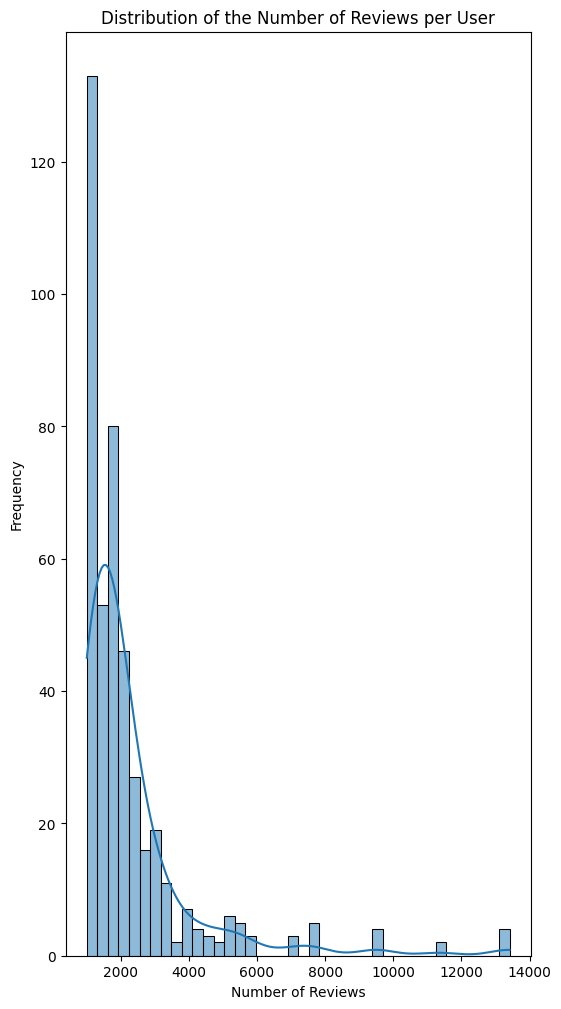

In [ ]:
# Plotting the distribution of the number of followers, for the famous reviewers
sns.histplot(df[df.Followers > 1000]['Followers'], kde=True)
plt.title('Distribution of the Number of Reviews per User')
plt.xlabel('Number of Reviews')
plt.ylabel('Frequency')
plt.show()

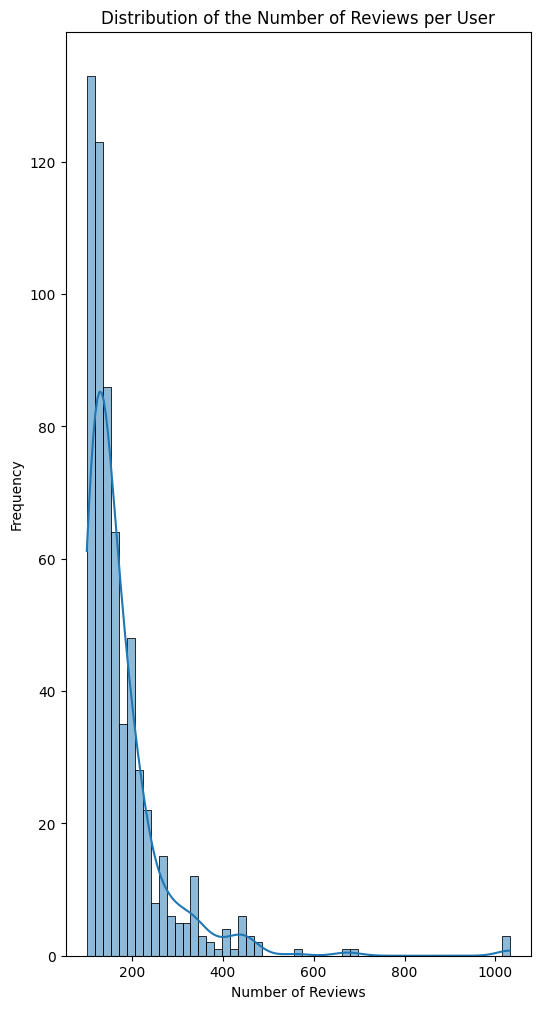

In [ ]:
# Plotting the distribution of the number of reviews per user
sns.histplot(df[df.Reviews > 100]['Reviews'], kde=True)
plt.title('Distribution of the Number of Reviews per User')
plt.xlabel('Number of Reviews')
plt.ylabel('Frequency')
plt.show()

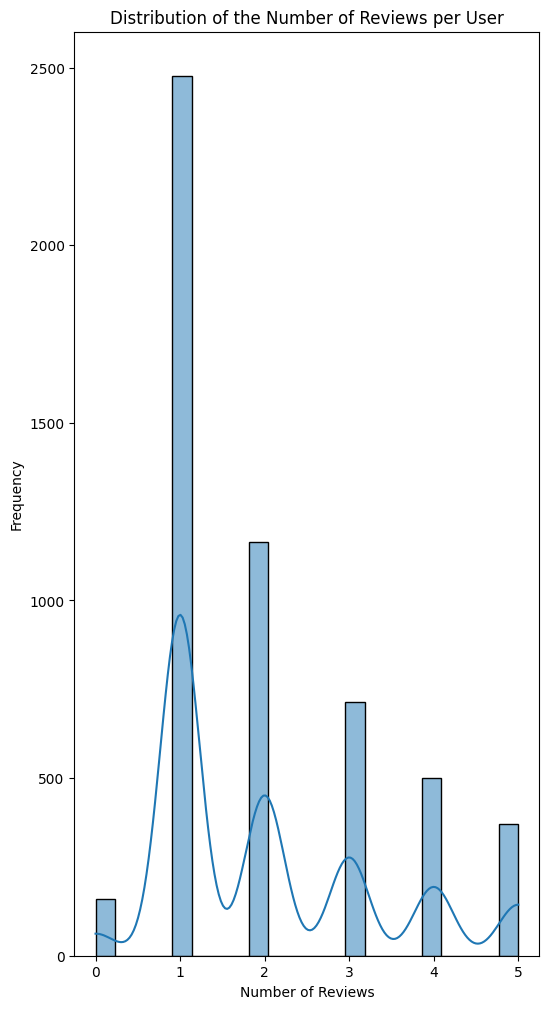

In [ ]:
sns.histplot(df[df.Reviews <= 5]['Reviews'], kde=True)
plt.title('Distribution of the Number of Reviews per User')
plt.xlabel('Number of Reviews')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Categorize users based on the number of reviews
def categorize_user(row):
    if row['Followers'] > 5000:
        return 'famous'
    elif row['Reviews'] <= 3:
        return 'Not Active'
    elif row['Reviews'] > 3 and row['Reviews'] <= 100:
        return 'Normal'
    else:
        return 'Active'

df['Reviewer_Type'] = df.apply(categorize_user, axis=1)

df.head()

,Restaurant,Review,Rating,Pictures,User_ID,Reviews,Followers,Review_Length,Sentiment,meal,season,Reviewer_Type
0,Beyond Flavours,the ambience was good food was quite good had...,5.0,0,1,1,2,215,positive,lunch,spring,Not Active
1,Beyond Flavours,ambience is too good for a pleasant evening se...,5.0,0,2,3,2,139,positive,lunch,spring,Not Active
2,Beyond Flavours,a must try great food great ambience thnx for ...,5.0,0,3,2,3,175,positive,dinner,spring,Not Active
3,Beyond Flavours,soumen das and arun was a great guy only becau...,5.0,0,4,1,1,144,positive,dinner,spring,Not Active
4,Beyond Flavours,food is goodwe ordered kodi drumsticks and bas...,5.0,0,5,3,2,153,positive,dinner,spring,Not Active


<ipython-input-35-67137ad3bcdc>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=user_counts, x='Reviewer_Type', y='Count', palette='viridis')


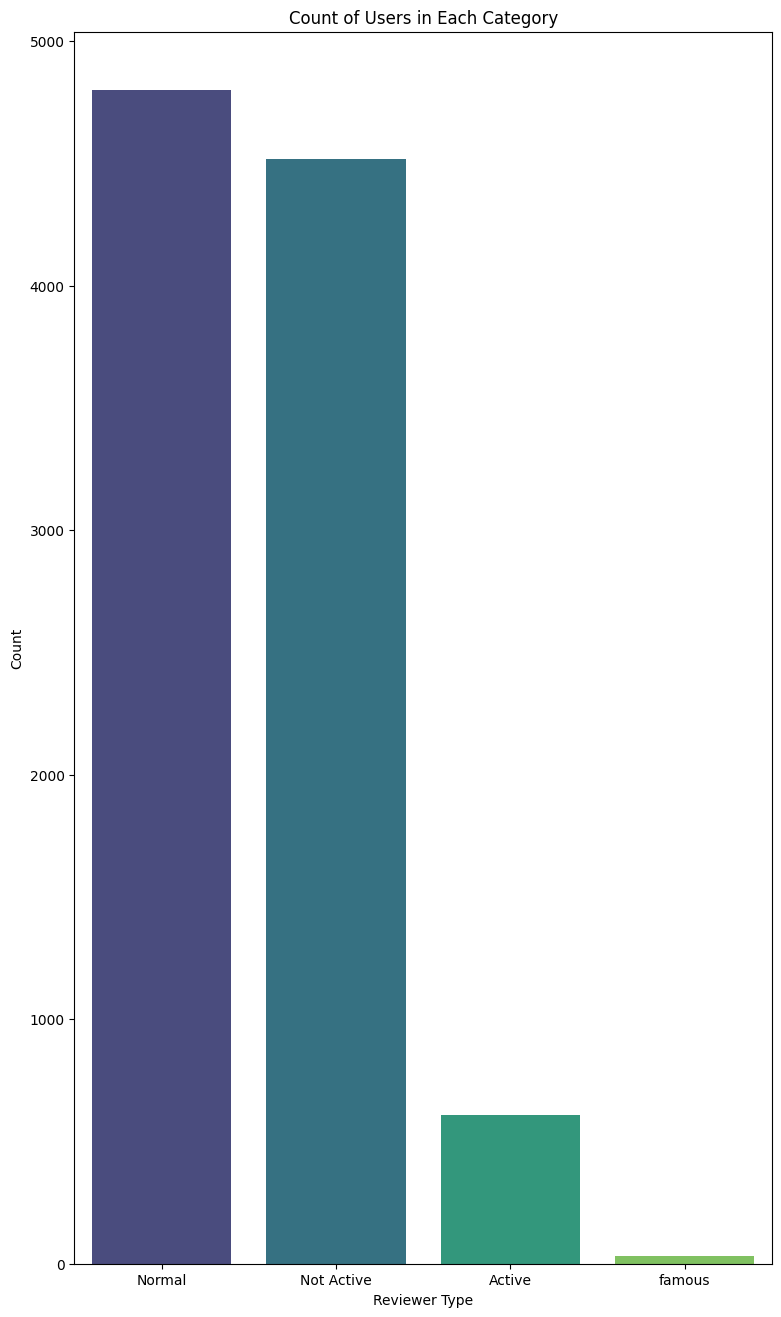

In [ ]:
user_counts = df['Reviewer_Type'].value_counts().reset_index()
user_counts.columns = ['Reviewer_Type', 'Count']

# Plotting the count of users in each category
plt.figure(figsize=(9, 16))
sns.barplot(data=user_counts, x='Reviewer_Type', y='Count', palette='viridis')
plt.title('Count of Users in Each Category')
plt.xlabel('Reviewer Type')
plt.ylabel('Count')
plt.show()

## ctegorize the reviews

In [ ]:
df.columns

Index(['Restaurant', 'Review', 'Rating', 'Pictures', 'User_ID', 'Reviews',
       'Followers', 'Review_Length', 'Sentiment', 'meal', 'season',
       'Reviewer_Type'],
      dtype='object')

In [ ]:
from transformers import pipeline
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", device=device)

cuda


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
reviews = df.Review.to_list()

candidate_labels = ["Food Quality", "Service", "Atmosphere", "Delivery", "Location", "Menu", "Price"]

results = classifier(reviews, candidate_labels)

In [ ]:
lables = [result['labels'][0] for result in results]
df['category'] = lables

In [ ]:
df.to_csv('Restaurant reviews_silver.csv', index=False)

In [ ]:
df.head()

,Restaurant,Review,Rating,Pictures,User_ID,Reviews,Followers,Review_Length,Sentiment,meal,season,Reviewer_Type,category
0,Beyond Flavours,the ambience was good food was quite good had...,5.0,0,1,1,2,215,positive,lunch,spring,Not Active,Atmosphere
1,Beyond Flavours,ambience is too good for a pleasant evening se...,5.0,0,2,3,2,139,positive,lunch,spring,Not Active,Service
2,Beyond Flavours,a must try great food great ambience thnx for ...,5.0,0,3,2,3,175,positive,dinner,spring,Not Active,Atmosphere
3,Beyond Flavours,soumen das and arun was a great guy only becau...,5.0,0,4,1,1,144,positive,dinner,spring,Not Active,Food Quality
4,Beyond Flavours,food is goodwe ordered kodi drumsticks and bas...,5.0,0,5,3,2,153,positive,dinner,spring,Not Active,Atmosphere


## gold data
only the feature needed for the analysis

In [ ]:
df = df.drop(columns=['Followers', 'Reviews', 'Pictures', 'Review'])
df.to_csv('Restaurant reviews_gold.csv', index=False)

# load gold data

The discription of the gold dataset:

The dataset containes 9961 review of 100 different restaurants and from 7917 different Reviewer.
- Restaurant: The name of the restaurant.
- Review: The review text.
- Rating: The rating in stars rom 1 to 5
- Pictures: The count pictures submitted with the review
- User_ID: The is of the reviewer
- Reviews: The count of reviews the user has in his account
- Followers: The count of followers the user has in his account
- Review_Length: the length of the review
- Sentiment: is the review positive or negative
- meal: the meal
- season: the year season
- Revier_Type: is the reviewer active or not
- category: what does the review talk about ["Food Quality", "Service", "Atmosphere", "Delivery", "Location", "Customer Service", "Menu", "Price"]

In [7]:
df = pd.read_csv("Restaurant reviews_gold.csv")

In [8]:
df.head(2)

,Restaurant,Rating,User_ID,Review_Length,Sentiment,meal,season,Reviewer_Type,category
0,Beyond Flavours,5.0,1,215,positive,lunch,spring,Not Active,Atmosphere
1,Beyond Flavours,5.0,2,139,positive,lunch,spring,Not Active,Service


In [9]:
print(df.info())
print(df.describe())

column_descriptions = {
    'Restaurant': 'Name of the restaurant',
    'Review': 'The review text',
    'Rating': 'The rating in stars from 1 to 5',
    'Pictures': 'Count of pictures submitted with the review',
    'User_ID': 'ID of the reviewer',
    'Reviews': 'Count of reviews the user has in their account',
    'Followers': 'Count of followers the user has in their account',
    'Review_Length': 'Length of the review',
    'meal': 'The meal type (e.g., breakfast, lunch, dinner)',
    'season': 'The year season',
    'Category': 'Category of the review (e.g., Food Quality, Service)',
    'Sentiment': 'Sentiment classification of the review (positive or negative)'
}
for col, desc in column_descriptions.items():
    print(f'{col}: {desc}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9954 entries, 0 to 9953
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Restaurant     9954 non-null   object 
 1   Rating         9954 non-null   float64
 2   User_ID        9954 non-null   int64  
 3   Review_Length  9954 non-null   int64  
 4   Sentiment      9954 non-null   object 
 5   meal           9954 non-null   object 
 6   season         9954 non-null   object 
 7   Reviewer_Type  9954 non-null   object 
 8   category       9954 non-null   object 
dtypes: float64(1), int64(2), object(6)
memory usage: 700.0+ KB
None
            Rating      User_ID  Review_Length
count  9954.000000  9954.000000    9954.000000
mean      3.600261  3620.117038     271.121358
std       1.483573  2278.997848     329.056184
min       1.000000     1.000000       1.000000
25%       3.000000  1588.250000     139.000000
50%       4.000000  3436.500000     183.000000
75%       5.

# Distribution of reviews per category

In [10]:
def plot_pivot_category(df, keyword):
  pivot_df = df.pivot_table(index='category', columns='Sentiment', aggfunc='size', fill_value=0)

  # Reset the index to use the category as a column
  pivot_df = pivot_df.reset_index()

  pivot_df.plot(
      kind='barh',
      stacked=True,
      x='category',
      color=['#1f77b4', '#2ca02c'],
      figsize=(6, 12)
  )

  plt.title(f'Amount of Positive and Negative Reviews per Category for ({keyword})')
  plt.xlabel('Count')
  plt.ylabel('Category')
  plt.xticks(rotation=45)
  plt.legend(title='Sentiment', loc='upper right')
  plt.show()

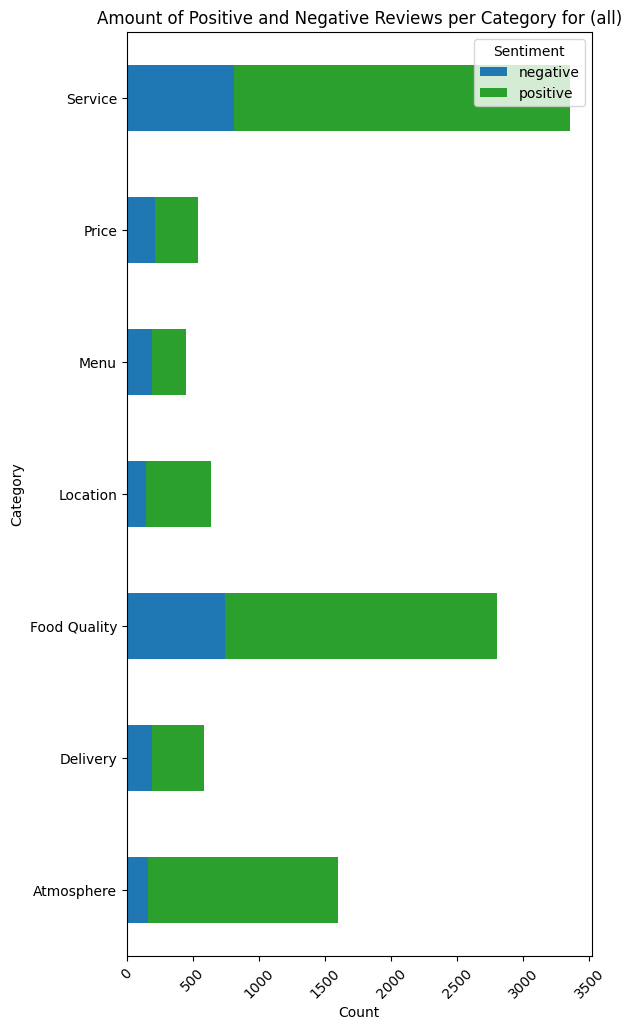

In [11]:
plot_pivot_category(df, 'all')

# Restaurants with higher deviation in rating

Text(0.5, 1.0, 'Standard Deviation of Ratings for Each Restaurant')

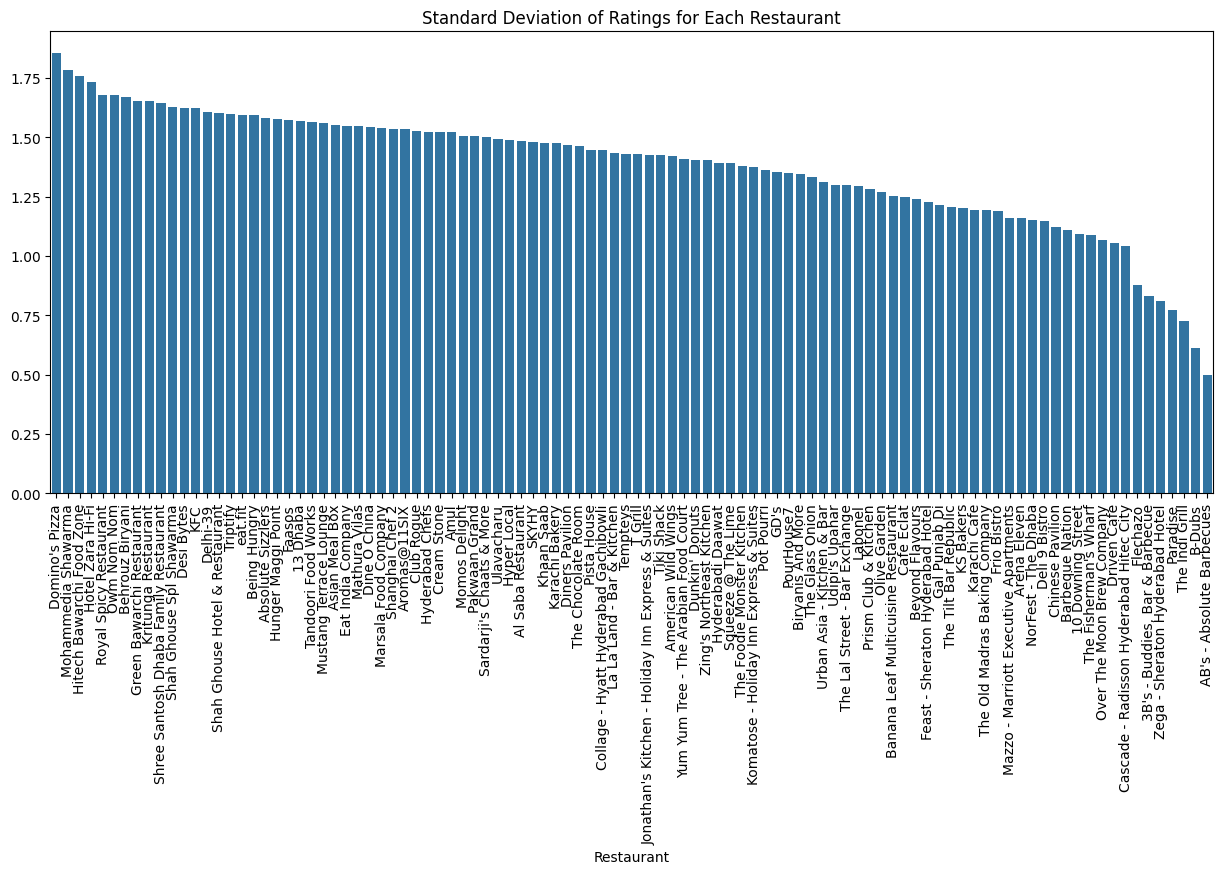

In [12]:
std_restaurants = df.groupby('Restaurant')['Rating'].std().sort_values(ascending=False)
plt.figure(figsize=(15, 6))
sns.barplot(x=std_restaurants.index, y=std_restaurants.values)
plt.xticks(rotation=90)
plt.title('Standard Deviation of Ratings for Each Restaurant')

## let's take domino's pizza as an example

In [13]:
domino = df[df['Restaurant'] == 'Domino\'s Pizza'] # AB's - Absolute Barbecues

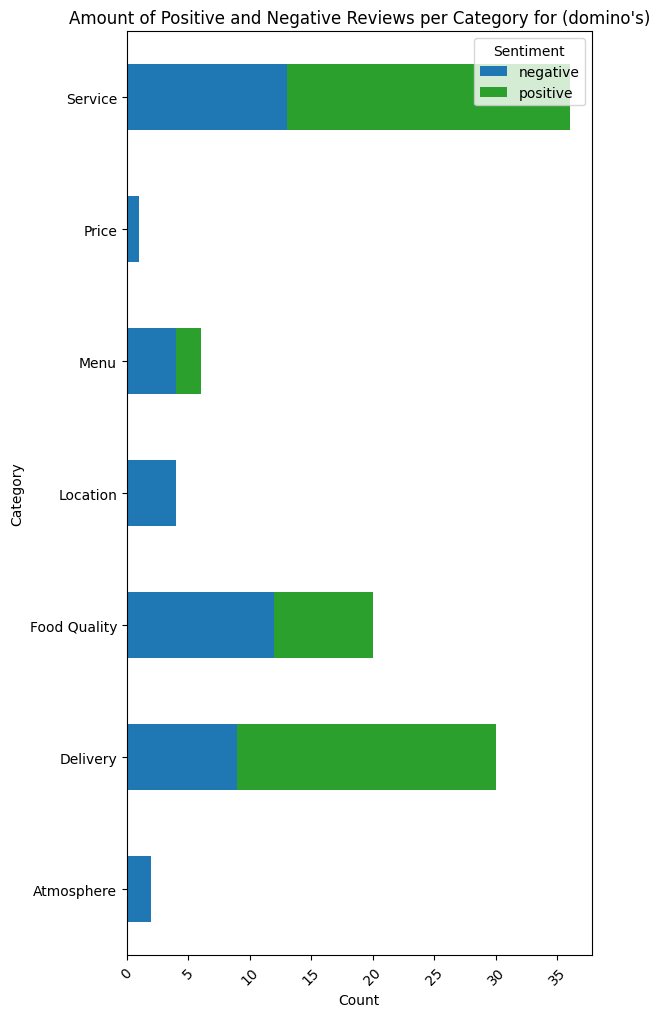

In [14]:
# here we see most of the variation in service and delivery, which makes since in such a large fast food chain,
# which dependes mostly on delivery.
plot_pivot_category(domino, 'domino\'s')

## Mohamedia shawrma

In [15]:
mohamedia = df[df['Restaurant'] == 'Mohammedia Shawarma']

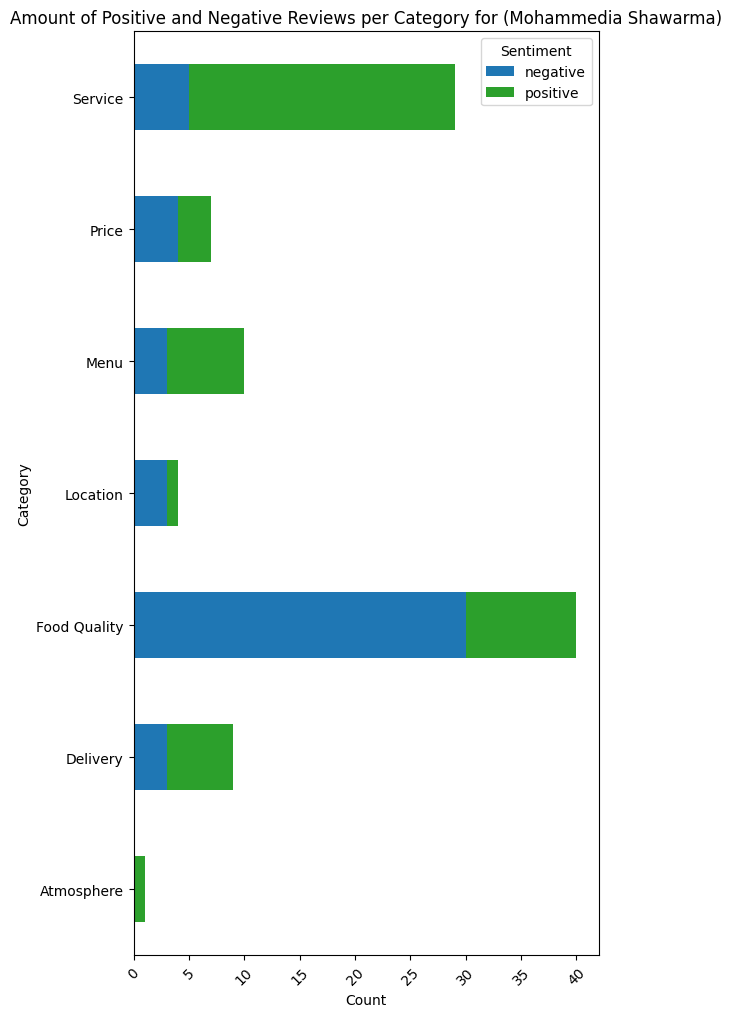

In [16]:
# the same here too, the differences in the customers openions differ the most in delivery and service
plot_pivot_category(mohamedia, 'Mohammedia Shawarma')

## AB's - Absolute Barbecues

In [17]:
Barbecues = df[df['Restaurant'] == 'AB\'s - Absolute Barbecues']

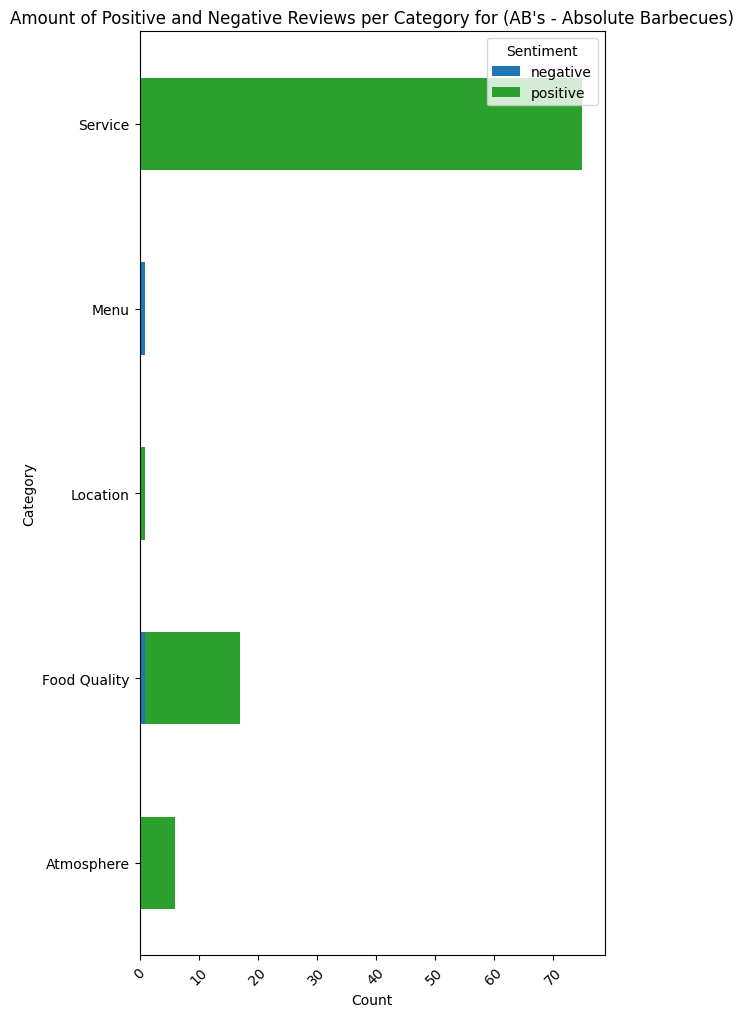

In [18]:
plot_pivot_category(Barbecues, 'AB\'s - Absolute Barbecues')

# When does a user who doesn't usualy give reviews give a review

a not active reviwers has 5 or less reviews

In [19]:
not_active_reviews = df[df['Reviewer_Type'] == 'Not Active']

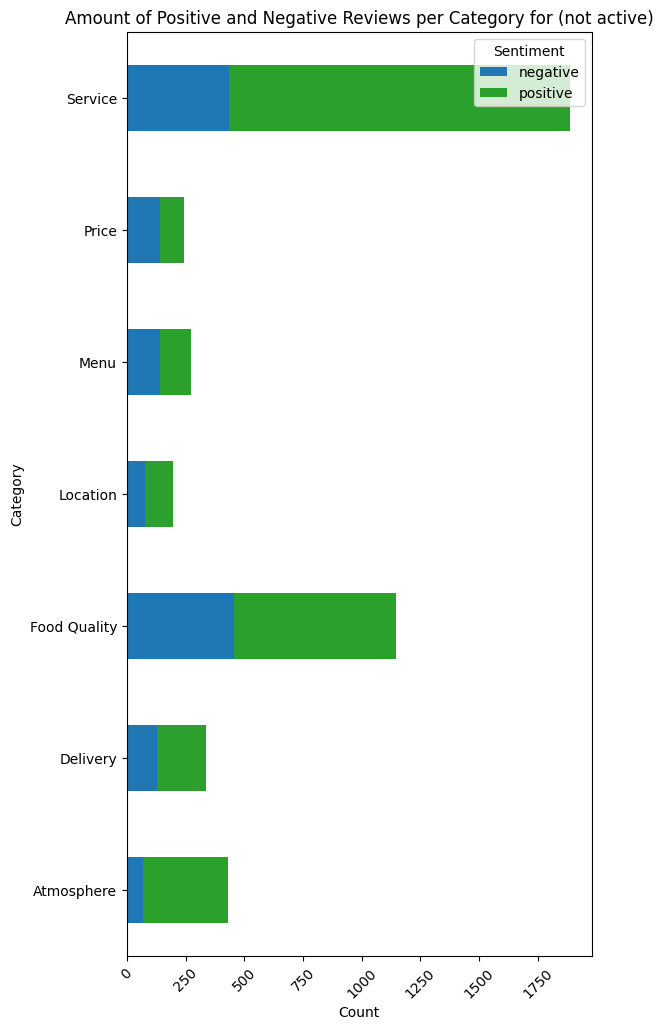

In [20]:
plot_pivot_category(not_active_reviews, 'not active')

C:\Users\3aboo\AppData\Local\Temp\ipykernel_23568\4098974236.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(not_active_reviews['Rating'], kde=True, bins=30, palette='viridis')


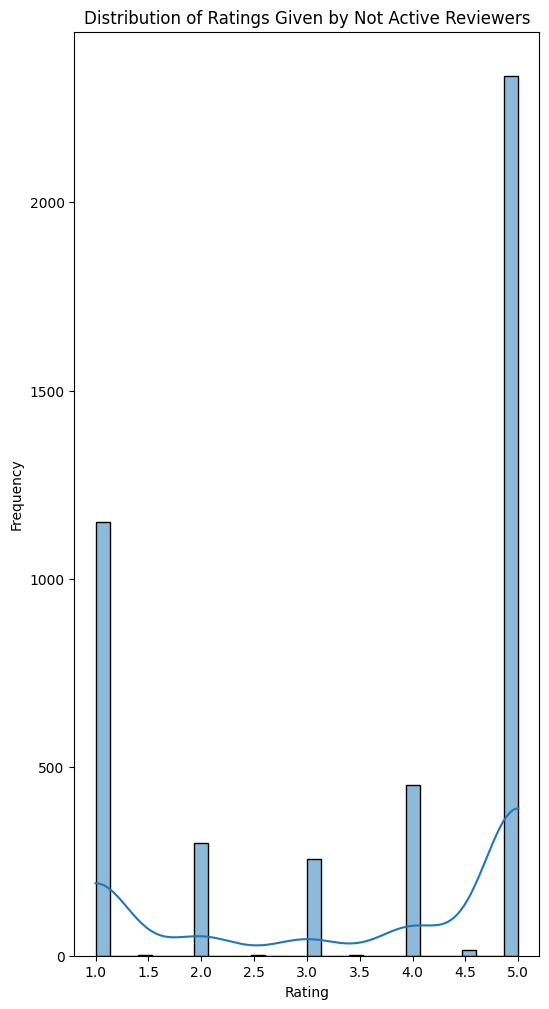

In [21]:
# plt.figure(figsize=(10, 6))
sns.histplot(not_active_reviews['Rating'], kde=True, bins=30, palette='viridis')
plt.title('Distribution of Ratings Given by Not Active Reviewers')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()


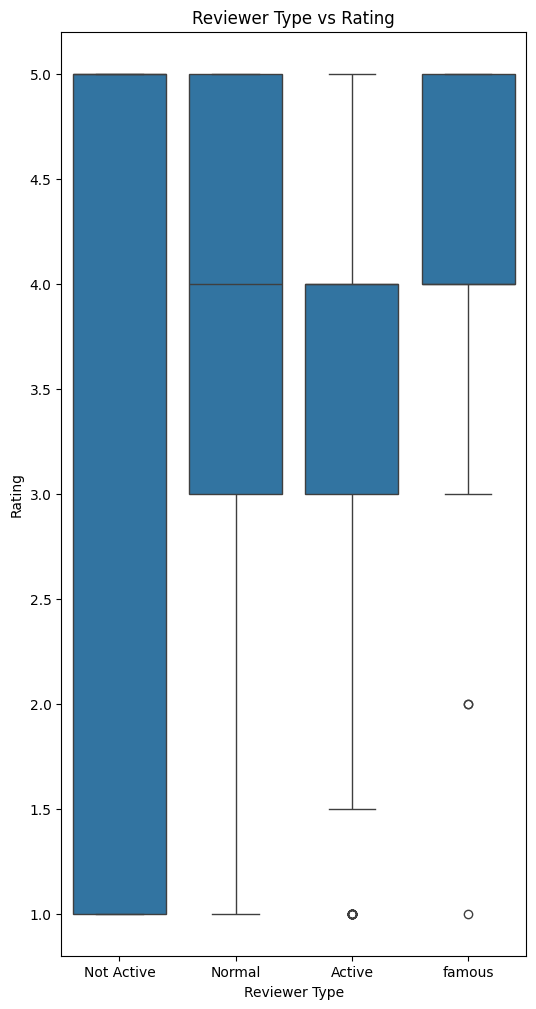

In [22]:
# don't show
# Is there is a difference betweeen the reviews of the active and none active people?
# why do we need to know this?
# Plotting the relationship between reviewer type and rating
sns.boxplot(data=df, x='Reviewer_Type', y='Rating')
plt.title('Reviewer Type vs Rating')
plt.xlabel('Reviewer Type')
plt.ylabel('Rating')
plt.show()

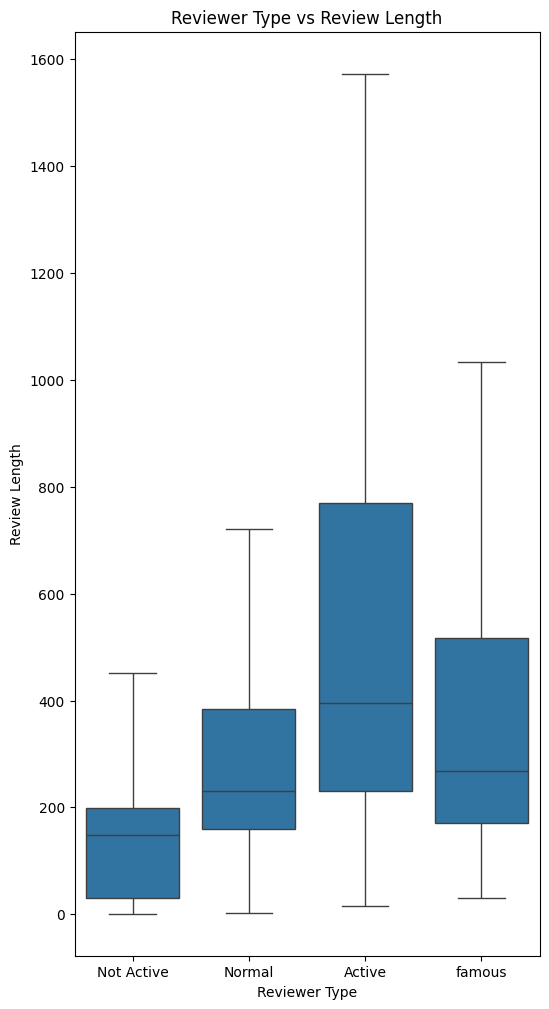

In [23]:
# don't show
# Plotting the relationship between reviewer type and review length
sns.boxplot(data=df, x='Reviewer_Type', y='Review_Length', showfliers=False)
plt.title('Reviewer Type vs Review Length')
plt.xlabel('Reviewer Type')
plt.ylabel('Review Length')
plt.show()

## Does the user leave a review when the restaurant already has many or few reviews?

In [24]:
# I was realy curios to know that, but unfortunatly we can't tell it from the data we have, bcs the sizes of the samples are almost the same
df.Restaurant.value_counts()

Restaurant
Beyond Flavours                          100
KS Bakers                                100
The Indi Grill                           100
The Tilt Bar Republic                    100
Yum Yum Tree - The Arabian Food Court    100
                                        ... 
The Old Madras Baking Company             99
Amul                                      99
Hyderabad Chefs                           98
Arena Eleven                              85
American Wild Wings                       77
Name: count, Length: 100, dtype: int64

# How honest are the people who give too many reviews?

## do hypothesis test
The very low Levene's p value suggests a big variance difference between both samples. For this reason we use Welch's t-test rather than standard t-test, which assumes a simmilar variance between both samples

The very low p value of Welch's t-test suggests, that there is a big differnce in the deviations between active and normal/non active users

In [25]:
def get_comparision_df(df, category):
  avg_rating_per_restaurant = df.groupby('Restaurant')['Rating'].mean().reset_index()
  avg_rating_per_restaurant.columns = ['Restaurant', 'Avg_Rating']

  not_active_reviews = df.merge(avg_rating_per_restaurant, on='Restaurant')
  # Filter reviews from 'Not Active' reviewers
  not_active_reviews = not_active_reviews[not_active_reviews['Reviewer_Type'] == category]

  # Calculate the difference between the review rating and the average restaurant rating
  not_active_reviews['Rating_Diff'] = not_active_reviews['Rating'] - not_active_reviews['Avg_Rating']

  return not_active_reviews['Rating_Diff']

In [26]:
from scipy.stats import ttest_ind, levene
# Separate active and non-active deviations
active_deviation = get_comparision_df(df, 'Active')
non_active_deviation = pd.concat([get_comparision_df(df, 'Normal'), get_comparision_df(df, 'Not Active')])

# Perform Levene's test for equal variances
levene_stat, levene_p = levene(active_deviation, non_active_deviation)
print(f"Levene's test for equal variances: Statistic={levene_stat}, p-value={levene_p}")

# Perform Welch's t-test (does not assume equal variances)
t_stat_welch, p_value_welch = ttest_ind(active_deviation, non_active_deviation, equal_var=False)
print(f"Welch's t-test: T-statistic={t_stat_welch}, p-value={p_value_welch}")

Levene's test for equal variances: Statistic=136.8011995089272, p-value=2.1414248400109048e-31
Welch's t-test: T-statistic=4.526491856323304, p-value=6.903025787646728e-06


In [27]:
def plot_rating_diff(df, ax, desc):
  # Plot for active reviewers
  sns.histplot(df, kde=True, ax=axes[ax])
  axes[ax].set_title(f'Rating Differences for {desc}')
  axes[ax].set_xlabel('Rating Difference (Reviewer Rating - Average Rating)')
  axes[ax].set_ylabel('Frequency')

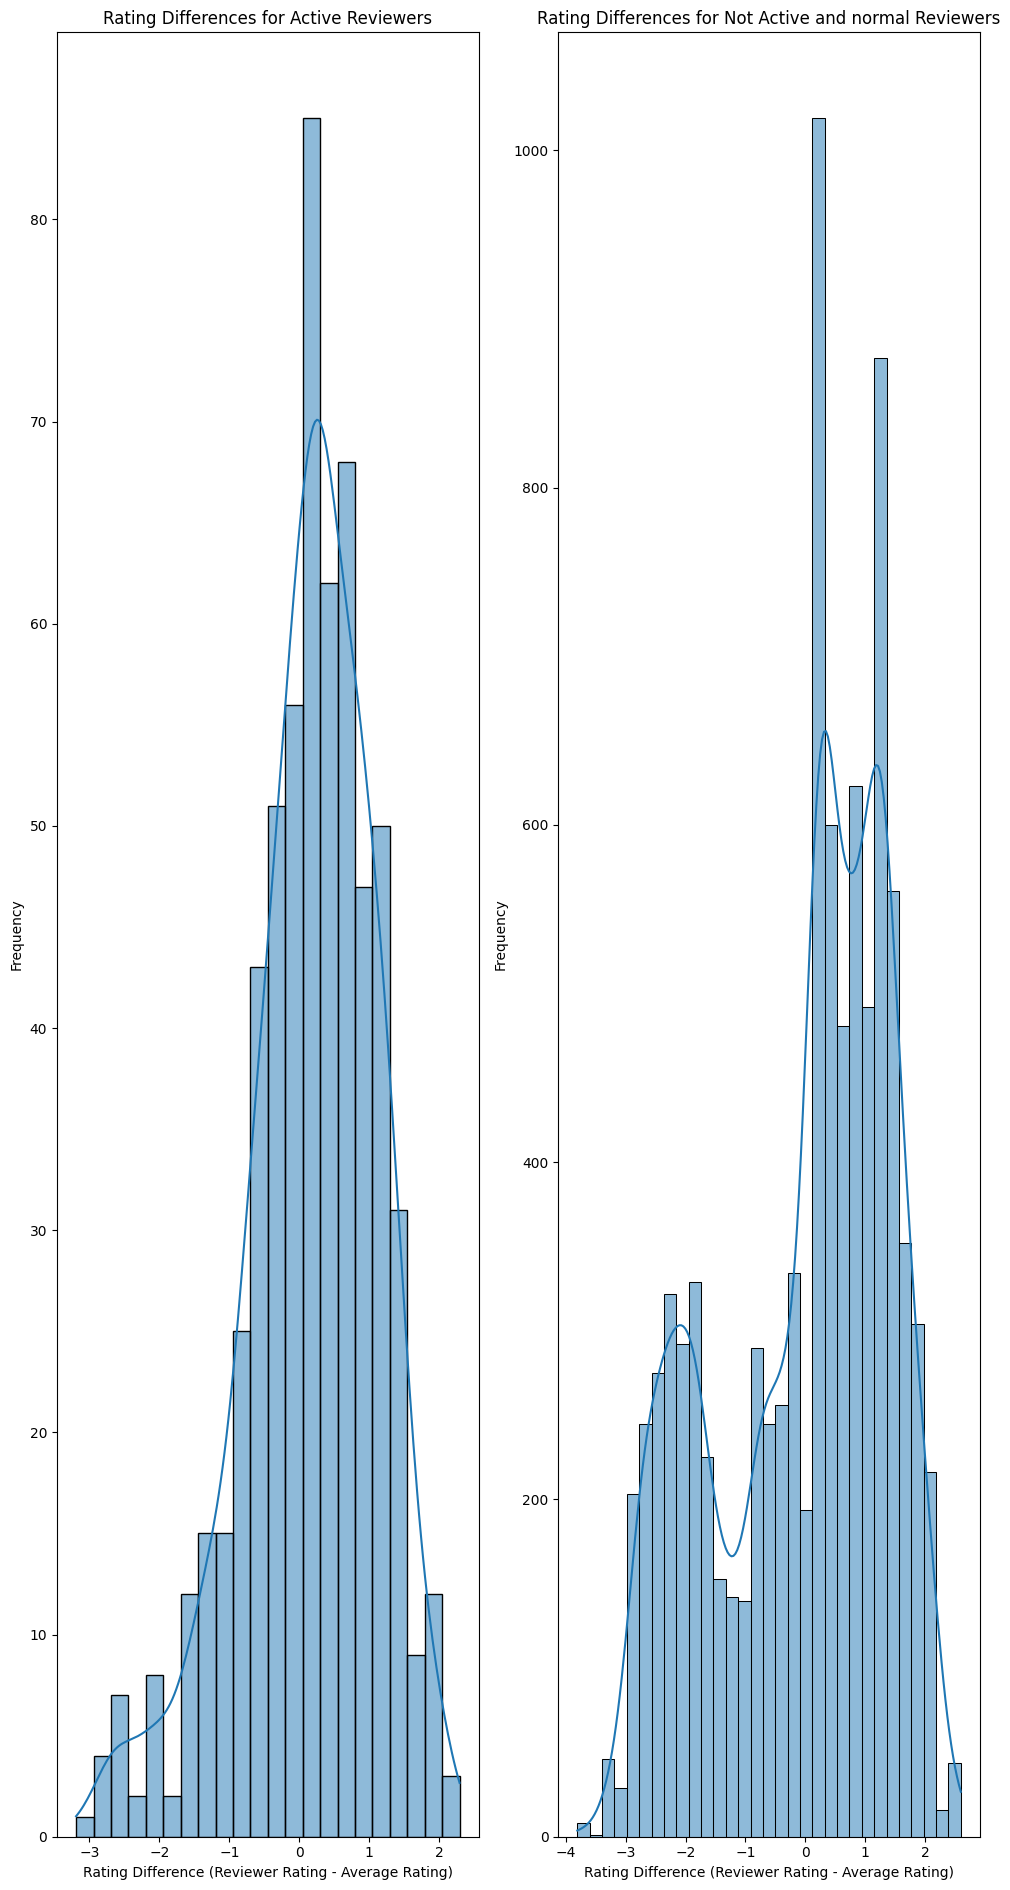

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(10, 19))

# Plot for active reviewers
plot_rating_diff(active_deviation, 0, 'Active Reviewers')

plot_rating_diff(non_active_deviation, 1, 'Not Active and normal Reviewers')

plt.tight_layout()

# Show the combined plot
plt.show()

## can we tell this by just comparing their reviews to the avarage reviews of the restaurant?

do they always give positive or negative? and how do their opinions vary from the others?

# How does the times of the year corelate with the ammount and quality of reviews

In [29]:
# Calculate the number of reviews per season
reviews_per_season = df['season'].value_counts().reset_index()
reviews_per_season.columns = ['season', 'Num_Reviews']


In [30]:
# Calculate the average rating per season
avg_rating_per_season = df.groupby('season')['Rating'].mean().reset_index()
avg_rating_per_season.columns = ['season', 'Avg_Rating']


In [31]:
# Merge the number of reviews and average rating dataframes
seasonal_analysis_df = reviews_per_season.merge(avg_rating_per_season, on='season')

# Display the first few rows to verify
print(seasonal_analysis_df.head())


   season  Num_Reviews  Avg_Rating
0  spring         3397    3.695614
1  summer         2567    3.609856
2  winter         2237    3.539785
3    fall         1753    3.478608


C:\Users\3aboo\AppData\Local\Temp\ipykernel_23568\2710952101.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=seasonal_analysis_df, x='season', y='Num_Reviews', palette='viridis')


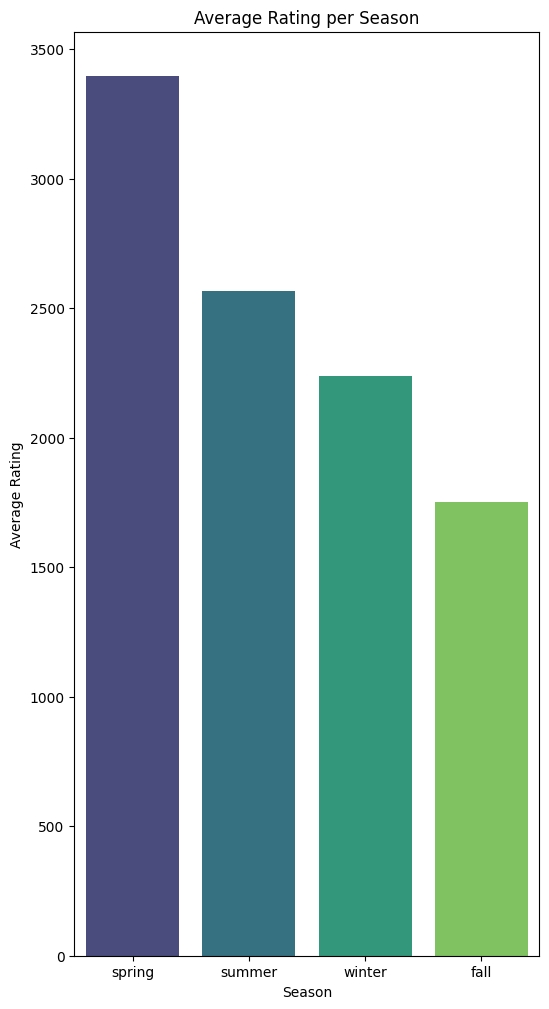

In [32]:
# change to line chart
# plt.figure(figsize=(10, 6))
sns.barplot(data=seasonal_analysis_df, x='season', y='Num_Reviews', palette='viridis')
plt.title('Average Rating per Season')
plt.xlabel('Season')
plt.ylabel('Average Rating')
plt.show()

C:\Users\3aboo\AppData\Local\Temp\ipykernel_23568\1716701406.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=seasonal_analysis_df, x='season', y='Avg_Rating', palette='viridis')


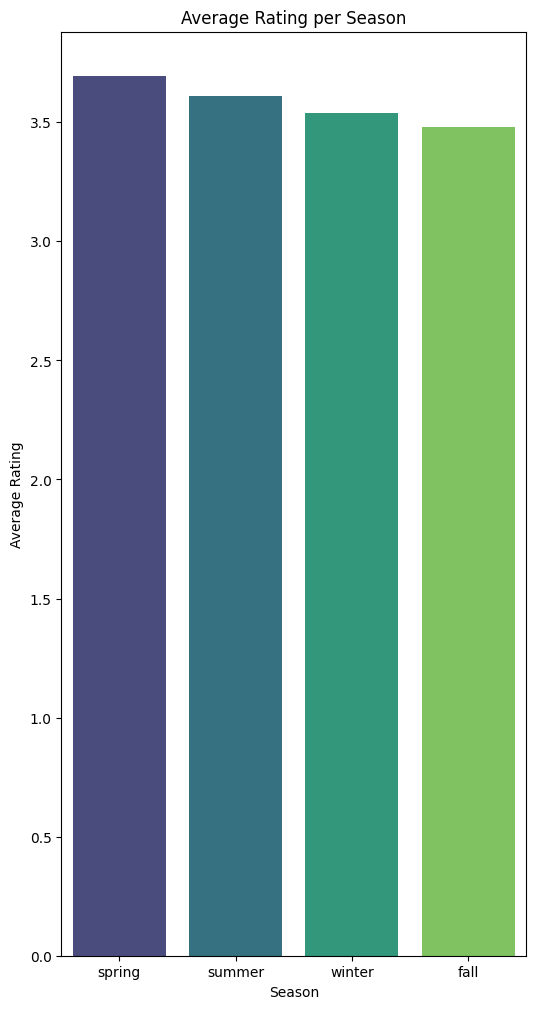

In [33]:
# plt.figure(figsize=(10, 6))
sns.barplot(data=seasonal_analysis_df, x='season', y='Avg_Rating', palette='viridis')
plt.title('Average Rating per Season')
plt.xlabel('Season')
plt.ylabel('Average Rating')
plt.show()


In [34]:

seasonal_analysis_df.set_index('season').T

season,spring,summer,winter,fall
Num_Reviews,3397.000000,2567.000000,2237.000000,1753.000000
Avg_Rating,3.695614,3.609856,3.539785,3.478608


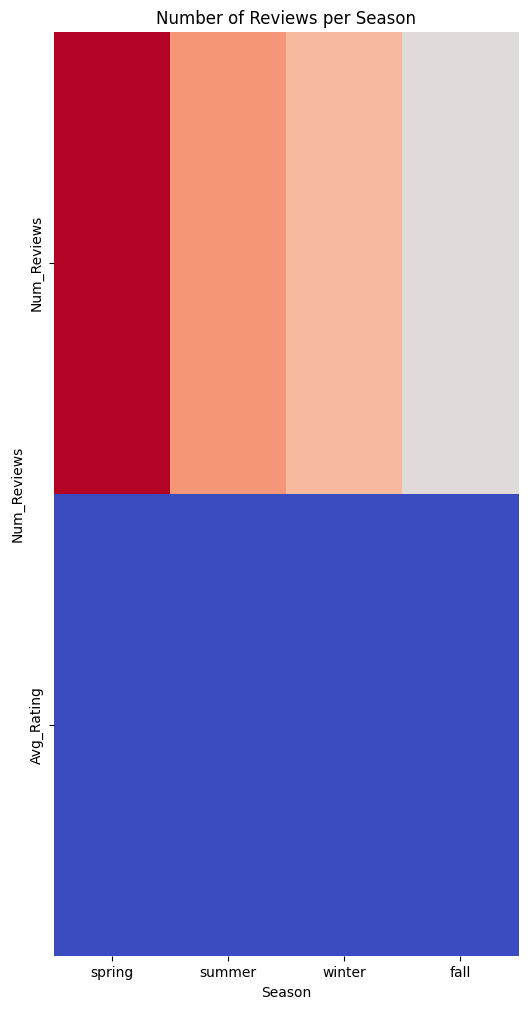

In [35]:
sns.heatmap(seasonal_analysis_df.set_index('season').T, annot=False, cmap='coolwarm', cbar=False)
plt.title('Number of Reviews per Season')
plt.xlabel('Season')
plt.ylabel('Num_Reviews')
plt.show()
